# Imports

In [1]:
%load_ext autoreload

In [2]:
import sys
sys.path.append('/home/hice1/mbibars3/scratch/vlm-debiasing/VLM-Debiasing-Project/scripts')

In [3]:
%autoreload 2
import pandas as pd
import numpy as np
import os
import model as m
import torch
import torch.nn as nn
import torch.optim as optim
import loaders
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [4]:
import random

def mixup_data(x1, x2, y1, y2, alpha=1.0):
    """
    Perform MixUp between two samples.
    
    Args:
        x1: The first sample (input tensor).
        x2: The second sample (input tensor).
        y1: The first label.
        y2: The second label.
        alpha: The mixing parameter (lambda), which controls the weight of each sample.

    Returns:
        mixed_x: The mixed input tensor.
        mixed_y: The mixed label tensor.
        lambda_value: The value of lambda (how much of each sample is mixed).
    """
    # Generate the mixing factor lambda from a Beta distribution
    lambda_value = torch.distributions.Beta(alpha, alpha).sample().item()

    # Perform MixUp for inputs
    mixed_x = lambda_value * x1 + (1 - lambda_value) * x2
    
    # Perform MixUp for labels
    mixed_y = lambda_value * y1 + (1 - lambda_value) * y2
    
    return mixed_x, mixed_y, lambda_value


In [5]:
import torch
import torch.nn as nn

class DeepConvLSTM(nn.Module):
    def __init__(self, input_channels, conv_channels, lstm_hidden_size, lstm_layers, output_size, dropout=0.5):
        """
        Args:
            input_channels: Number of input features (25 for your data).
            conv_channels: Number of output channels for the convolutional layers.
            lstm_hidden_size: Hidden size of the LSTM.
            lstm_layers: Number of LSTM layers.
            output_size: Size of the model output (e.g., number of classes for classification or 1 for regression).
            dropout: Dropout rate.
        """
        super(DeepConvLSTM, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv1d(input_channels, conv_channels, kernel_size=9, stride=1, padding=2)
        self.conv2 = nn.Conv1d(conv_channels, conv_channels, kernel_size=9, stride=1, padding=2)
        self.relu = nn.LeakyReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # LSTM layers
        self.lstm = nn.LSTM(input_size=conv_channels, 
                            hidden_size=lstm_hidden_size, 
                            num_layers=lstm_layers, 
                            batch_first=True, 
                            dropout=dropout)
        
        # Fully connected output layer
        self.fc = nn.Linear(lstm_hidden_size, output_size)
    
    def forward(self, x):
        """
        Args:
            x: Input tensor of shape (batch_size, time_steps, features).
        
        Returns:
            Output tensor.
        """
        # Input shape: (batch_size, time_steps, features)
        # Permute to match Conv1d input: (batch_size, features, time_steps)
        x = x.permute(0, 2, 1)
        
        # Pass through convolutional layers
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)  # Shape: (batch_size, conv_channels, reduced_time_steps)
        
        # Permute back for LSTM: (batch_size, reduced_time_steps, conv_channels)
        x = x.permute(0, 2, 1)
        
        # Pass through LSTM
        x, (h_n, c_n) = self.lstm(x)
        
        # Take the output of the last time step: (batch_size, lstm_hidden_size)
        x = x[:, -1, :]
        
        # Pass through fully connected layer
        x = self.fc(x)
        
        return x


In [6]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np

class PatientAudioDatasetCSV(Dataset):
    def __init__(self, dataframe, input_column, label_column=None, normalize=True):
        """
        Args:
            dataframe: DataFrame containing file paths and labels.
            input_column: Column name containing paths to the CSV files.
            label_column: Column name containing labels (if supervised learning).
            normalize: Whether to normalize the data (0-1 scaling).
        """
        self.dataframe = dataframe
        self.input_column = input_column
        self.label_column = label_column
        self.normalize = normalize

        # Compute normalization statistics (if enabled)
        if self.normalize:
            self.mean, self.std = self._compute_normalization_stats()
    
    def _compute_normalization_stats(self):
        """Compute mean and standard deviation across all data in the train split."""
        all_data = []
        for path in self.dataframe[self.input_column]:
            audio_data = np.load(path, allow_pickle=True)
            all_data.append(audio_data)
        all_data = np.concatenate(all_data, axis=0)
        return all_data.mean(axis=0), all_data.std(axis=0)

    def _normalize(self, data):
        """Normalize data using computed mean and std."""
        return (data - self.mean) / self.std

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        # Load audio data from CSV
        audio_path = row[self.input_column]
        audio_data = np.load(audio_path, allow_pickle=True).astype(np.float32)

        # Normalize if required
        if self.normalize:
            audio_data = self._normalize(audio_data)

        # Convert to tensor
        audio_tensor = torch.tensor(audio_data)

        # Load label if available
        if self.label_column:
            label = torch.tensor(row[self.label_column], dtype=torch.float32)
            return audio_tensor, label
        else:
            return audio_tensor


# eGEMAPS

In [7]:
features_csv = pd.read_csv("/home/hice1/mbibars3/scratch/vlm-debiasing/data/e-daic/audio_text_visual_paths.csv", index_col="Unnamed: 0")
features_csv.head()

,split,label,label.1,gender,audio,text,visual,aud_egemaps
0,train,22.0,0,female,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...
1,test,23.0,0,male,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...
2,train,19.0,0,male,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...
3,train,67.0,1,female,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...
4,dev,39.0,0,male,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...


In [8]:
# Shuffle the DataFrame
features_csv = features_csv.sample(frac=1, random_state=42).reset_index(drop=True)

In [36]:
import torch
import torch.nn.functional as F

def _aggregate_features(data, mean, std):
    
    # Calculate median
    median = data.median(dim=0).values

    # Calculate min and max
    min_val = data.min(dim=0).values
    max_val = data.max(dim=0).values

    # Calculate 25th and 75th percentiles (Interquartile Range)
    q25 = np.quantile(data, 0.25, dim=0)
    q75 = np.quantile(data, 0.75, dim=0)

    # Calculate skewness (using third central moment)
    mean_centered = data - mean
    skewness = (mean_centered ** 3).mean(dim=0) / (std ** 3)

    # Calculate kurtosis (using fourth central moment)
    kurtosis = (mean_centered ** 4).mean(dim=0) / (std ** 4)

    # Concatenate all the statistical features
    return [
        mean, std, median, min_val, max_val, q25, q75, skewness, kurtosis
    ]

def _compute_normalization_stats_aggregate(dataframe, path_col):
    i = 0
    all_data = []
    for path in dataframe[path_col]:
        audio_data = pd.read_csv(path, delimiter=";", header=None, usecols=lambda x: x not in ["name", "frameTime"])
        audio_data = audio_data.select_dtypes(exclude='object').values.astype(np.float32)
        all_data.append(audio_data)
    all_data = np.concatenate(all_data, axis=0)
    m, st = all_data.mean(axis=0), all_data.std(axis=0)
    data = _aggregate_features(all_data, m, st)
    m, st = data.mean(axis=0), data.std(axis=0)
    return (data - m) / st


In [37]:
d = _compute_normalization_stats_aggregate(features_csv[features_csv["split"]=="train"], "aud_egemaps")

/scratch/956230/ipykernel_107623/3217025537.py:33: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  audio_data = pd.read_csv(path, delimiter=";", header=None, usecols=lambda x: x not in ["name", "frameTime"])
/scratch/956230/ipykernel_107623/3217025537.py:33: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  audio_data = pd.read_csv(path, delimiter=";", header=None, usecols=lambda x: x not in ["name", "frameTime"])
/scratch/956230/ipykernel_107623/3217025537.py:33: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  audio_data = pd.read_csv(path, delimiter=";", header=None, usecols=lambda x: x not in ["name", "frameTime"])
/scratch/956230/ipykernel_10762

AttributeError: 'numpy.ndarray' object has no attribute 'median'

In [ ]:
print(d.shape)

In [31]:
train_dataset = PatientAudioDatasetCSV(features_csv[features_csv["split"]=="train"], input_column="aud_egemaps", label_column="label")

/scratch/956230/ipykernel_107623/3585190051.py:20: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  audio_data = pd.read_csv(path, delimiter=";", header=None, usecols=lambda x: x not in ["name", "frameTime"])
/scratch/956230/ipykernel_107623/3585190051.py:20: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  audio_data = pd.read_csv(path, delimiter=";", header=None, usecols=lambda x: x not in ["name", "frameTime"])
/scratch/956230/ipykernel_107623/3585190051.py:20: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  audio_data = pd.read_csv(path, delimiter=";", header=None, usecols=lambda x: x not in ["name", "frameTime"])
/scratch/956230/ipykernel_10762

In [32]:
batch_size = 4
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

for batch_data, batch_labels in dataloader:
    print(f"Data Shape: {batch_data.shape}, Labels Shape: {batch_labels.shape}")

/scratch/956230/ipykernel_107623/3585190051.py:35: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  audio_data = pd.read_csv(audio_path, delimiter=";", header=None, usecols=lambda x: x not in ["name", "frameTime"])
/scratch/956230/ipykernel_107623/3585190051.py:35: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  audio_data = pd.read_csv(audio_path, delimiter=";", header=None, usecols=lambda x: x not in ["name", "frameTime"])
/scratch/956230/ipykernel_107623/3585190051.py:35: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  audio_data = pd.read_csv(audio_path, delimiter=";", header=None, usecols=lambda x: x not in ["name", "frameTime"])
/scratch/9562

RuntimeError: Cannot pack empty tensors.

# Audio_AST9

In [38]:
fle = np.load("/home/hice1/mbibars3/scratch/vlm-debiasing/data/e-daic/untarred/301_P/301_AUDIO_ast9.npy")
fle.shape

(1214, 768)

In [40]:
features_csv = pd.read_csv("/home/hice1/mbibars3/scratch/vlm-debiasing/data/e-daic/audio_text_visual_paths.csv")

In [42]:
features_csv.head()

,split,label,label.1,gender,audio,text,visual,aud_egemaps,aud_ast
0,train,22.0,0,female,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...
1,test,23.0,0,male,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...
2,train,19.0,0,male,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...
3,train,67.0,1,female,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...
4,dev,39.0,0,male,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...


In [179]:
input_column = 'aud_ast'
label_column = 'label.1'

train_dataset = PatientAudioDatasetCSV(features_csv[features_csv["split"]=="train"], input_column=input_column, label_column=label_column, normalize=True)
dev_dataset = PatientAudioDatasetCSV(features_csv[features_csv["split"]=="dev"], input_column=input_column, label_column=label_column, normalize=True)


In [180]:
from torch.utils.data import DataLoader

batch_size = 10
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)


for batch_data, batch_labels in dataloader:
    print(f"Data Shape: {batch_data.shape}, Labels Shape: {batch_labels.shape}")


Data Shape: torch.Size([4, 1214, 768]), Labels Shape: torch.Size([4])
Data Shape: torch.Size([4, 1214, 768]), Labels Shape: torch.Size([4])
Data Shape: torch.Size([4, 1214, 768]), Labels Shape: torch.Size([4])
Data Shape: torch.Size([4, 1214, 768]), Labels Shape: torch.Size([4])
Data Shape: torch.Size([4, 1214, 768]), Labels Shape: torch.Size([4])
Data Shape: torch.Size([4, 1214, 768]), Labels Shape: torch.Size([4])
Data Shape: torch.Size([4, 1214, 768]), Labels Shape: torch.Size([4])
Data Shape: torch.Size([4, 1214, 768]), Labels Shape: torch.Size([4])
Data Shape: torch.Size([4, 1214, 768]), Labels Shape: torch.Size([4])
Data Shape: torch.Size([4, 1214, 768]), Labels Shape: torch.Size([4])
Data Shape: torch.Size([4, 1214, 768]), Labels Shape: torch.Size([4])
Data Shape: torch.Size([4, 1214, 768]), Labels Shape: torch.Size([4])
Data Shape: torch.Size([4, 1214, 768]), Labels Shape: torch.Size([4])
Data Shape: torch.Size([4, 1214, 768]), Labels Shape: torch.Size([4])
Data Shape: torch.Si

In [232]:
input_channels = 768  # Number of input features per time step
conv_channels = 64   # Number of convolutional filters
lstm_hidden_size = 128  # LSTM hidden size
lstm_layers = 2      # Number of LSTM layers
output_size = 1     # Number of classes for classification (or 1 for regression)

model = DeepConvLSTM(input_channels, conv_channels, lstm_hidden_size, lstm_layers, output_size)


In [233]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

710913

In [234]:
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, gamma = 1.0):
        super(FocalLoss, self).__init__()
        self.gamma = torch.tensor(gamma, dtype = torch.float32)
        self.eps = 1e-6
        
    def forward(self, input, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss) # prevents nans when probability 0
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return focal_loss.mean()

In [235]:
learning_rate = 0.001
num_epochs = 20
mix_prob = 0.5
alpha = 1.0
# Define loss function and optimizer
#criterion = RMSLELoss()
 # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [236]:
labels_torch = torch.from_numpy(features_csv[features_csv["split"]=="train"]["label.1"].values)

In [237]:
# Calculate class weights
class_counts = torch.bincount(labels_torch)  # Get counts for each class
class_weights = len(labels_torch) / (2.0 * class_counts)

# Apply weights to loss function
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[0])  # Weight for positive class


In [238]:
class_weights

tensor([0.7149, 1.6633])

In [239]:
from sklearn.metrics import f1_score
# Define variables to track losses
train_losses = []
val_losses = []
best_val_loss = float('inf')  # Initialize best validation loss

# Training loop
for epoch in range(num_epochs):
    model.train()

    running_train_loss = 0.0
    all_train_labels = []
    all_train_preds = []
    all_dev_labels = []
    all_dev_preds = []

    for batch in train_dataloader:
        _btch, labels = batch
        optimizer.zero_grad()
        inputs = _btch
        output = model(inputs)
        
        labels = labels.view(output.shape)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        running_train_loss += loss.item()
        # Convert logits to predictions
        preds = torch.sigmoid(output) > 0.5
        #print(np.unique(preds.detach().numpy()))
        all_train_labels.extend(labels.cpu().numpy().flatten())
        all_train_preds.extend(preds.cpu().numpy().flatten())

    # Average training loss for the epoch
    train_loss = running_train_loss / len(train_dataloader)
    train_losses.append(train_loss)

    # Validation Phase
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0

    with torch.no_grad():  # Disable gradient computation
        for batch in dev_dataloader:  # Use validation DataLoader
            _btch, labels = batch

            # Forward pass
            inputs = _btch
            output = model(inputs)

            # Reshape labels to match the output shape if necessary
            labels = labels.view(output.shape)

            # Compute loss
            loss = criterion(output, labels)
            #loss = torch.sqrt(loss)

            running_val_loss += loss.item()
            preds = torch.sigmoid(output) > 0.5
            all_dev_labels.extend(labels.cpu().numpy().flatten())
            all_dev_preds.extend(preds.cpu().numpy().flatten())

    # Average validation loss for the epoch
    val_loss = running_val_loss / len(dev_dataloader)
    val_losses.append(val_loss)

    # Check if this is the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print("best val loss ", epoch, ": ", best_val_loss)
        #torch.save(model.state_dict(), "best_aud_text_model.pth")  # Save best model

    # Compute F1-score for training
    train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
    dev_f1 = f1_score(all_dev_labels, all_dev_preds, average='weighted')

    # Print epoch summary
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train F1: {train_f1:.4f}, Val F1: {dev_f1:.4f}")
    #print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


best val loss  0 :  0.5539926091829935
Epoch [1/20], Train Loss: 0.6002, Val Loss: 0.5540, Train F1: 0.5757, Val F1: 0.5718
best val loss  1 :  0.5037714590628942
Epoch [2/20], Train Loss: 0.5287, Val Loss: 0.5038, Train F1: 0.5757, Val F1: 0.5718
best val loss  2 :  0.5025575657685598
Epoch [3/20], Train Loss: 0.4898, Val Loss: 0.5026, Train F1: 0.5757, Val F1: 0.5718
Epoch [4/20], Train Loss: 0.4892, Val Loss: 0.5030, Train F1: 0.5757, Val F1: 0.5718
best val loss  4 :  0.5023574630419413
Epoch [5/20], Train Loss: 0.4874, Val Loss: 0.5024, Train F1: 0.5757, Val F1: 0.5718
Epoch [6/20], Train Loss: 0.4854, Val Loss: 0.5024, Train F1: 0.5757, Val F1: 0.5718
best val loss  6 :  0.5002653499444326
Epoch [7/20], Train Loss: 0.4824, Val Loss: 0.5003, Train F1: 0.5757, Val F1: 0.5718
best val loss  7 :  0.4977220396200816
Epoch [8/20], Train Loss: 0.4703, Val Loss: 0.4977, Train F1: 0.5757, Val F1: 0.5718
Epoch [9/20], Train Loss: 0.4493, Val Loss: 0.5060, Train F1: 0.5757, Val F1: 0.5718
b

: 

: 

In [231]:
torch.save(model.state_dict(), "deepconvlstm_overfit_classification_model.pth")  # Save best model

In [217]:
# Model prediction
model.eval()  # Set model to evaluation mode

predictions = []
with torch.no_grad():  # Disable gradient computation
    for batch in dev_dataloader:
        _data, labels = batch
        output = model(_data)  # Model's prediction
        predicts = torch.sigmoid(output)  # Apply sigmoid activation
        predicted_classes = (predicts > 0.5).int()  # Convert probabilities to binary predictions
        #print(f"Predicted Probabilities:\n{predictions}")
        #print(f"Predicted Classes:\n{predicted_classes}")
        # Collect predictions
        #predictions.append(output)
        predictions.append(predicted_classes)

# Combine predictions into a single tensor
#predictions = torch.cat(predicted_classes, dim=0)
#y_pred = np.array(predictions)
out = np.concatenate(predictions).ravel()

print(f"Predictions:\n{np.unique(out)}")

Predictions:
[0 1]


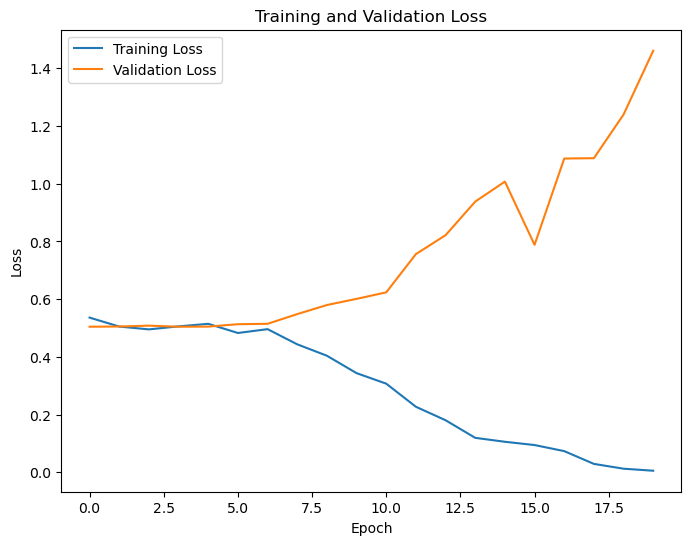

In [218]:
# Plot training and validation losses
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.savefig("loss_plot.png")  # Save the plot
plt.show()

In [219]:
y_pred= out

In [226]:
y_test = np.array(features_csv[features_csv["split"]=="dev"]["label"].values)

In [221]:
np.unique(features_csv['gender'])

array(['female', 'male', 'unknown'], dtype=object)

In [222]:
features_csv['col_encoded'] = features_csv['gender'].map({'female': 0, 'male': 1, 'unknown':1})

In [223]:
np.unique(features_csv['col_encoded'])

array([0, 1])

In [227]:
from fairlearn.metrics import demographic_parity_difference

# Assuming `gender` corresponds to the original metadata
# Split the dataset into training and testing sets for `gender`
gender_train, gender_test = features_csv[features_csv["split"]=="dev"]["col_encoded"], features_csv[features_csv["split"]=="dev"]["col_encoded"]

# Ensure that `gender_test`, `y_test`, and `y_pred` are aligned
print(f"Shape of gender_test: {gender_train.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_pred: {y_pred.shape}")



Shape of gender_test: (56,)
Shape of y_test: (56,)
Shape of y_pred: (56,)


In [228]:
# Calculate Demographic Parity Difference
demographic_parity = demographic_parity_difference(
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=gender_train
)

print(f"Demographic Parity Difference: {demographic_parity}")

Demographic Parity Difference: 0.04444444444444445


In [229]:
from fairlearn.metrics import MetricFrame, selection_rate
metric_frame = MetricFrame(metrics=selection_rate, 
                           y_true=y_test, 
                           y_pred=y_pred, 
                           sensitive_features=gender_train)

# Get selection rates for each group
selection_rates = metric_frame.by_group
print("Selection Rates by Group:")
print(selection_rates)


Selection Rates by Group:
col_encoded
0    0.100000
1    0.055556
Name: selection_rate, dtype: float64


In [230]:
group_a_rate = selection_rates[1]
group_b_rate = selection_rates[0]

if group_b_rate > 0:  # Avoid division by zero
    demographic_parity_ratio = group_a_rate / group_b_rate
    print(f"Demographic Parity Ratio: {demographic_parity_ratio}")

Demographic Parity Ratio: 0.5555555555555555


# Audio_AST9_2

In [7]:
fle = np.load("/home/hice1/mbibars3/scratch/vlm-debiasing/data/e-daic/untarred/301_P/301_AUDIO_ast9.npy")
fle.shape

(1214, 768)

In [8]:
features_csv = pd.read_csv("/home/hice1/mbibars3/scratch/vlm-debiasing/data/e-daic/audio_text_visual_paths.csv")

In [9]:
features_csv.head()

,split,label,label.1,gender,audio,text,visual,aud_egemaps,aud_ast
0,train,22.0,0,female,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...
1,test,23.0,0,male,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...
2,train,19.0,0,male,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...
3,train,67.0,1,female,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...
4,dev,39.0,0,male,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...


In [38]:
input_column = 'aud_ast'
label_column = 'label.1'

train_dataset = PatientAudioDatasetCSV(features_csv[features_csv["split"]=="train"], input_column=input_column, label_column=label_column, normalize=True)
dev_dataset = PatientAudioDatasetCSV(features_csv[features_csv["split"]=="dev"], input_column=input_column, label_column=label_column, normalize=True)
test_dataset = PatientAudioDatasetCSV(features_csv[features_csv["split"]=="test"], input_column=input_column, label_column=label_column, normalize=True)

In [39]:
from torch.utils.data import DataLoader

batch_size = 10
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
"""
for batch_data, batch_labels in dataloader:
    print(f"Data Shape: {batch_data.shape}, Labels Shape: {batch_labels.shape}")
"""

'\nfor batch_data, batch_labels in dataloader:\n    print(f"Data Shape: {batch_data.shape}, Labels Shape: {batch_labels.shape}")\n'

In [12]:
input_channels = 768  # Number of input features per time step
conv_channels = 64   # Number of convolutional filters
lstm_hidden_size = 128  # LSTM hidden size
lstm_layers = 2      # Number of LSTM layers
output_size = 1     # Number of classes for classification (or 1 for regression)

model = DeepConvLSTM(input_channels, conv_channels, lstm_hidden_size, lstm_layers, output_size)


In [13]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

710913

In [14]:
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, gamma = 1.0):
        super(FocalLoss, self).__init__()
        self.gamma = torch.tensor(gamma, dtype = torch.float32)
        self.eps = 1e-6
        
    def forward(self, input, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss) # prevents nans when probability 0
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return focal_loss.mean()

In [15]:
learning_rate = 0.001
num_epochs = 20
mix_prob = 0.5
alpha = 1.0
# Define loss function and optimizer
#criterion = RMSLELoss()
 # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
labels_torch = torch.from_numpy(features_csv[features_csv["split"]=="train"]["label.1"].values)

In [17]:
# Calculate class weights
class_counts = torch.bincount(labels_torch)  # Get counts for each class
class_weights = len(labels_torch) / (2.0 * class_counts)

# Apply weights to loss function
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[0])  # Weight for positive class


In [18]:
class_weights

tensor([0.7149, 1.6633])

In [20]:
from sklearn.metrics import f1_score
# Define variables to track losses
train_losses = []
val_losses = []
train_f1s = []
val_f1s = []
best_val_f1 = float('-inf')  # Initialize best validation loss

# Training loop
for epoch in range(num_epochs):
    model.train()

    running_train_loss = 0.0
    all_train_labels = []
    all_train_preds = []
    all_dev_labels = []
    all_dev_preds = []

    for batch in train_dataloader:
        _btch, labels = batch
        optimizer.zero_grad()
        inputs = _btch
        output = model(inputs)
        
        labels = labels.view(output.shape)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        running_train_loss += loss.item()
        # Convert logits to predictions
        preds = torch.sigmoid(output) > 0.5
        #print(np.unique(preds.detach().numpy()))
        all_train_labels.extend(labels.cpu().numpy().flatten())
        all_train_preds.extend(preds.cpu().numpy().flatten())

    # Average training loss for the epoch
    train_loss = running_train_loss / len(train_dataloader)
    train_losses.append(train_loss)

    # Validation Phase
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0

    with torch.no_grad():  # Disable gradient computation
        for batch in dev_dataloader:  # Use validation DataLoader
            _btch, labels = batch

            # Forward pass
            inputs = _btch
            output = model(inputs)

            # Reshape labels to match the output shape if necessary
            labels = labels.view(output.shape)

            # Compute loss
            loss = criterion(output, labels)
            #loss = torch.sqrt(loss)

            running_val_loss += loss.item()
            preds = torch.sigmoid(output) > 0.5
            all_dev_labels.extend(labels.cpu().numpy().flatten())
            all_dev_preds.extend(preds.cpu().numpy().flatten())

    # Average validation loss for the epoch
    val_loss = running_val_loss / len(dev_dataloader)
    val_losses.append(val_loss)
    
    # Compute F1-score for training
    train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
    dev_f1 = f1_score(all_dev_labels, all_dev_preds, average='weighted')

    train_f1s.append(train_f1)
    val_f1s.append(dev_f1)

    # Check if this is the best model
    if dev_f1 > best_val_f1:
        best_val_f1 = dev_f1
        print("best val f1 ", epoch, ": ", best_val_f1)
        torch.save(model.state_dict(), "deepconvlstm_overfit2_classification_model.pth")  

    

    # Print epoch summary
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train F1: {train_f1:.4f}, Val F1: {dev_f1:.4f}")
    #print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


best val f1  0 :  0.5718045112781954
Epoch [1/20], Train Loss: 0.5516, Val Loss: 0.5089, Train F1: 0.5757, Val F1: 0.5718
Epoch [2/20], Train Loss: 0.5167, Val Loss: 0.5099, Train F1: 0.5757, Val F1: 0.5718
Epoch [3/20], Train Loss: 0.4909, Val Loss: 0.5138, Train F1: 0.5757, Val F1: 0.5718
Epoch [4/20], Train Loss: 0.4886, Val Loss: 0.5153, Train F1: 0.5757, Val F1: 0.5718
Epoch [5/20], Train Loss: 0.4658, Val Loss: 0.5376, Train F1: 0.5757, Val F1: 0.5718
Epoch [6/20], Train Loss: 0.4230, Val Loss: 0.5246, Train F1: 0.5768, Val F1: 0.5718
Epoch [7/20], Train Loss: 0.3617, Val Loss: 0.7214, Train F1: 0.6256, Val F1: 0.4117
Epoch [8/20], Train Loss: 0.4599, Val Loss: 0.7981, Train F1: 0.6707, Val F1: 0.5718
Epoch [9/20], Train Loss: 0.4877, Val Loss: 0.5510, Train F1: 0.5757, Val F1: 0.5718
Epoch [10/20], Train Loss: 0.3867, Val Loss: 0.5151, Train F1: 0.5757, Val F1: 0.5718
best val f1  10 :  0.6836187068745209
Epoch [11/20], Train Loss: 0.3101, Val Loss: 0.5636, Train F1: 0.7729, Val

In [21]:
input_channels = 768  # Number of input features per time step
conv_channels = 64   # Number of convolutional filters
lstm_hidden_size = 128  # LSTM hidden size
lstm_layers = 2      # Number of LSTM layers
output_size = 1     # Number of classes for classification (or 1 for regression)

best_model = DeepConvLSTM(input_channels, conv_channels, lstm_hidden_size, lstm_layers, output_size)
best_model.load_state_dict(torch.load("deepconvlstm_overfit2_classification_model.pth", weights_only=True))

<All keys matched successfully>

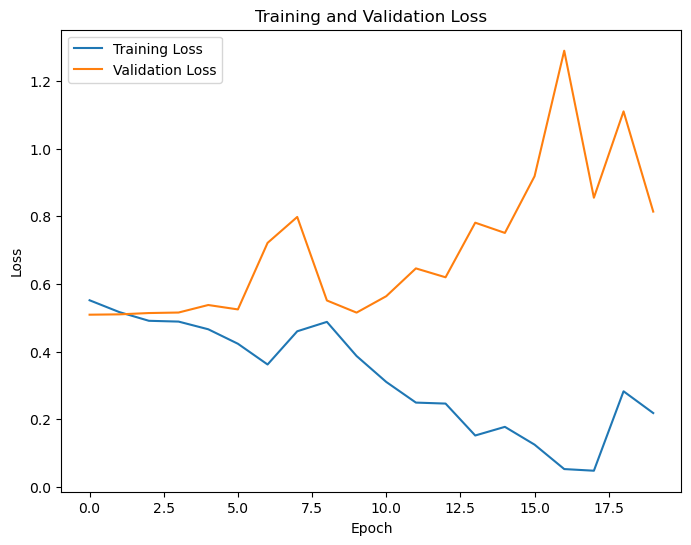

In [23]:
# Plot training and validation losses
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.savefig("overfit2_loss_plot.png")  # Save the plot
plt.show()

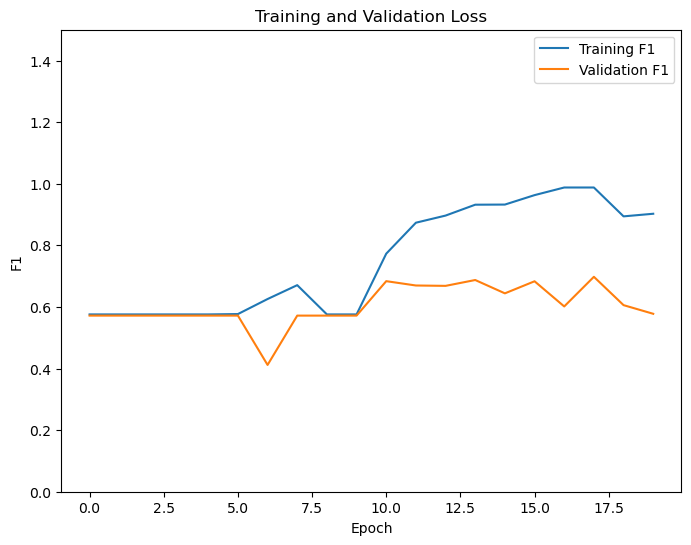

In [25]:
# Plot training and validation losses
plt.figure(figsize=(8, 6))
plt.plot(train_f1s, label="Training F1")
plt.plot(val_f1s, label="Validation F1")
plt.xlabel("Epoch")
plt.ylabel("F1")
plt.ylim([0,1.5])
plt.title("Training and Validation Loss")
plt.legend()
plt.savefig("overfit2_f1_plot.png")  # Save the plot
plt.show()

In [40]:
# Model prediction
best_model.eval()  # Set model to evaluation mode

predictions = []
with torch.no_grad():  # Disable gradient computation
    for batch in test_dataloader:
        _data, labels = batch
        output = best_model(_data)  # Model's prediction
        predicts = torch.sigmoid(output)  # Apply sigmoid activation
        predicted_classes = (predicts > 0.5).int()  # Convert probabilities to binary predictions
        #print(f"Predicted Probabilities:\n{predictions}")
        #print(f"Predicted Classes:\n{predicted_classes}")
        # Collect predictions
        #predictions.append(output)
        predictions.append(predicted_classes)

# Combine predictions into a single tensor
#predictions = torch.cat(predicted_classes, dim=0)
#y_pred = np.array(predictions)
out = np.concatenate(predictions).ravel()

print(f"Predictions:\n{np.unique(out)}")

Predictions:
[0 1]


In [41]:
y_pred= out

In [42]:
y_test = np.array(features_csv[features_csv["split"]=="test"]["label"].values)

In [43]:
np.unique(features_csv['gender'])

array(['female', 'male', 'unknown'], dtype=object)

In [44]:
features_csv['col_encoded'] = features_csv['gender'].map({'female': 0, 'male': 1, 'unknown':1})

In [45]:
np.unique(features_csv['col_encoded'])

array([0, 1])

In [46]:
from fairlearn.metrics import demographic_parity_difference

# Assuming `gender` corresponds to the original metadata
# Split the dataset into training and testing sets for `gender`
gender_train, gender_test = features_csv[features_csv["split"]=="test"]["col_encoded"], features_csv[features_csv["split"]=="test"]["col_encoded"]

# Ensure that `gender_test`, `y_test`, and `y_pred` are aligned
print(f"Shape of gender_test: {gender_train.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_pred: {y_pred.shape}")



Shape of gender_test: (56,)
Shape of y_test: (56,)
Shape of y_pred: (56,)


In [47]:
# Calculate Demographic Parity Difference
demographic_parity = demographic_parity_difference(
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=gender_train
)

print(f"Demographic Parity Difference: {demographic_parity}")

Demographic Parity Difference: 0.047619047619047616


In [48]:
from fairlearn.metrics import MetricFrame, selection_rate
metric_frame = MetricFrame(metrics=selection_rate, 
                           y_true=y_test, 
                           y_pred=y_pred, 
                           sensitive_features=gender_train)

# Get selection rates for each group
selection_rates = metric_frame.by_group
print("Selection Rates by Group:")
print(selection_rates)


Selection Rates by Group:
col_encoded
0    0.285714
1    0.333333
Name: selection_rate, dtype: float64


In [49]:
group_a_rate = selection_rates[1]
group_b_rate = selection_rates[0]

if group_b_rate > 0:  # Avoid division by zero
    demographic_parity_ratio = group_a_rate / group_b_rate
    print(f"Demographic Parity Ratio: {demographic_parity_ratio}")

Demographic Parity Ratio: 1.1666666666666667
